In [1]:
#import libs

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
import torch.multiprocessing as mp

import gymnasium as gym

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
plt.rcParams["figure.figsize"] = (10, 5)

cuda


In [2]:
#Khởi tạo môi trường

env_name = "InvertedPendulum-v4"
# Create and wrap the environment
env = gym.make(env_name)
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

# Observation-space of InvertedPendulum-v4 (4)
obs_space_dims = env.observation_space.shape[0]
# Action-space of InvertedPendulum-v4 (1)
action_space_dims = env.action_space.shape[0]
rewards_over_seeds = []


In [3]:
#Tạo folder kết quả

import os
def mkdir(path): 
    if not os.path.exists(path):
        os.mkdir(path)

save_path = "./save"
env_path = f'{save_path}/{env_name}'
model_path = f'{save_path}/{env_name}/model'
demo_path = f'{save_path}/{env_name}/demo'

mkdir(save_path)
mkdir(env_path)
mkdir(model_path)
mkdir(demo_path)

In [4]:
# Import necessary libraries
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# Set the seed and other training parameters
seed_set = [1]
total_num_episodes = 100000  # Total number of episodes
evaluation_interval = 1000
learning_rate = 3e-4

# Initialize an empty list to store rewards over different seeds
rewards_over_seeds = []

for seed in seed_set:
    # Set the random seed for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Initialize the SAC agent
    model = SAC("MlpPolicy", env, verbose=0, seed=seed, learning_rate=learning_rate)

    rewards = []

    for episode in range(0, total_num_episodes + 1, evaluation_interval):
        if episode > 0:
            # Continue training the agent
            model.learn(total_timesteps=evaluation_interval)

        # Evaluate the agent
        mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
        print(f"Seed: {seed}, Episode: {episode}, Mean Reward: {mean_reward}, Std Reward: {std_reward}")
        rewards.append((episode, mean_reward))

        # Save the model
        model.save(f"{model_path}/{env_name}_sac_seed_{seed}_episode_{episode}")

    rewards_over_seeds.append(rewards)

# Output the rewards for different seeds
print(rewards_over_seeds)


2024-06-02 04:11:23.258916: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/admin/miniconda3/envs/tue.cm210908/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Seed: 1, Episode: 0, Mean Reward: 10.8, Std Reward: 0.39999999999999997
Seed: 1, Episode: 1000, Mean Reward: 66.6, Std Reward: 3.32264954516723
Seed: 1, Episode: 2000, Mean Reward: 88.4, Std Reward: 7.130217387990355
Seed: 1, Episode: 3000, Mean Reward: 116.5, Std Reward: 5.869412236331676
Seed: 1, Episode: 4000, Mean Reward: 108.7, Std Reward: 3.8223029707232787
Seed: 1, Episode: 5000, Mean Reward: 115.7, Std Reward: 2.491987158875422
Seed: 1, Episode: 6000, Mean Reward: 89.7, Std Reward: 1.5524174696260025
Seed: 1, Episode: 7000, Mean Reward: 189.1, Std Reward: 23.08007798946962
Seed: 1, Episode: 8000, Mean Reward: 193.2, Std Reward: 14.084033513166604
Seed: 1, Episode: 9000, Mean Reward: 143.9, Std Reward: 6.073713855624086
Seed: 1, Episode: 10000, Mean Reward: 147.1, Std Reward: 2.467792535850613
Seed: 1, Episode: 11000, Mean Reward: 175.7, Std Reward: 7.239475119095307
Seed: 1, Episode: 12000, Mean Reward: 150.2, Std Reward: 2.7856776554368237
Seed: 1, Episode: 13000, Mean Reward:

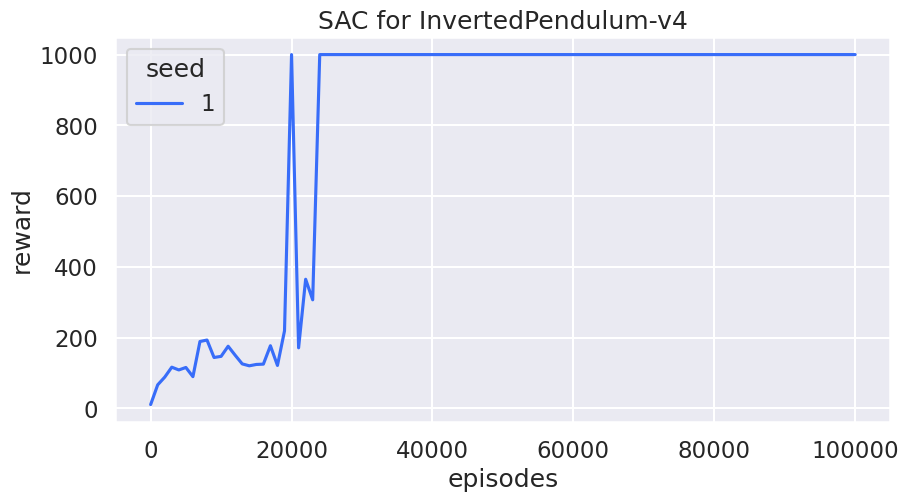

In [5]:
# ploting
rewards_to_plot = []
for seed_index, seed_rewards in enumerate(rewards_over_seeds):
    for episode, reward in seed_rewards:
        rewards_to_plot.append([seed_set[seed_index], episode, reward])
 
df1 = pd.DataFrame(rewards_to_plot, columns=["seed", "episodes", "reward"])
 
# Visualize the rewards
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", hue="seed", data=df1).set(
    title="SAC for InvertedPendulum-v4"
)
plt.show()

In [ ]:
#Visualize

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from PIL import Image
%matplotlib inline

# Function to visualize the trained model
def visualize_trained_model(agent, env_name="InvertedPendulum-v4", num_episodes=1, seed=1):
    env = gym.make(env_name, render_mode='rgb_array')
    frames = []
    
    # Set seed for reproducibility
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    for episode in range(num_episodes):
        obs, info = env.reset(seed=seed)
        done = False
        while not done:
            frame = env.render()
            frames.append(frame)
            action = agent.sample_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
    
    env.close()

    # Create animation
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(frames[0])

    def update(frame):
        im.set_array(frame)
        return [im]

    ani = FuncAnimation(fig, update, frames=frames, interval=50)
    plt.close()
    display(HTML(ani.to_jshtml()))

    frames = [Image.fromarray(frame) for frame in frames]
    frames[0].save(f'{demo_path}\{env_name}_reinforce_seed_{seed}.gif', save_all=True, append_images=frames[1:], loop=0, duration=50)
    
    return ani

visualize_trained_model(model, env_name="InvertedPendulum-v4")